# Mobile Robotics Project Report
### **Group 31:** Chiara Delvecchio, Camille Dorster, Junseo Um, Jérôme Courdacy

**Task Distribution**:  
Chiara:  
Camille:  
Junseo: Kalman filter  
Jérôme:  

# Table of contents

## Introduction

Talk about the environment and choices we made.

## Vision

In [1]:
import cv2
import numpy as np
import vision_utils as vu
import pathplanning_utils as pu
import control_utils as cu
import asyncio
import time
import math
import matplotlib.pyplot as plt
from tdmclient import ClientAsync
from ekf_pose import EKFPose


# --- CONFIG ---
CFG = {
    "CAM": 0, "RES": (1920, 1080), "MAP": (1000, 700), "MTX": "calibration_matrix.npy",
    "IDS": (0, 1), "AREA": 100,
    "THRESH": (600, 1000), "GAIN": 0.06, "BLIND": 0.5, "KIDNAP": 10
}

Vision initialization:  

The goal of the initialization is to provide the Vision object with all the necessary attributes to perform all the tasks needed. We provide constants like the `camera_index` and camera frame dimensions `cam_width` and `cam_height`. We also define the dimensions of the post-calibration frame, corresponding to the `map_width`and `map_height` of our robot's map in pixels. We also provide information about the ArUco indices corresponding to the thymio and goal using `thymio_marker_id` and `goal_marker_id`. Finally we pass it the transformation matrix path in `matrix_file_path`.

During the initialization of the Vision system, we connect to the webcam using the index provided and try to load it if it already exists. If it doesn't, we compute it.

In [2]:
raw_frame = cv2.imread("raw_frame.png")
vision = vu.Vision(CFG["CAM"], *CFG["RES"], *CFG["MAP"], CFG["MTX"], *CFG["IDS"], CFG["AREA"], test_frame = raw_frame)

2025-12-04 20:31:34.423 python[10244:26905761] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


Perspective Transformation: Homography

In order to work only with the the map and not the whole raw camera frame, we need to perform a transformation called homography. Homography allows us to, using a homography matrix, transform our raw frame from the camera to a map-specific frame. 

In order to compute the homography matrix, we need to find four points in our raw frame which we know the raw coordinates of, as well as their post-transformation coordinates. In order to do this, we use four corner AruCos. We get their raw coordinates, corresponding to the coordinates of the corners of our map. Since these points ar the map corners, we can easily obtain their post-transformation coordinates using the transformed frame width and height.

During the calibration, the camera system detects the corner ArUcos automatically but a user confirmation is required to make sure that the obtained corner coordinates are correct.

Once computed, the matrix is stored at the indicated path and can be reused while the camera and map setup doesn't change. We can now obtain the post-transformation warped frame that we will use in the rest of the project. Now, we are ready to detect the global obstacles.

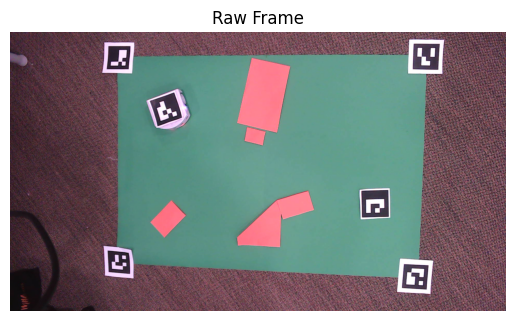

In [3]:
plt.imshow(cv2.cvtColor(raw_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Raw Frame')
plt.show()

perspective calibration explanation

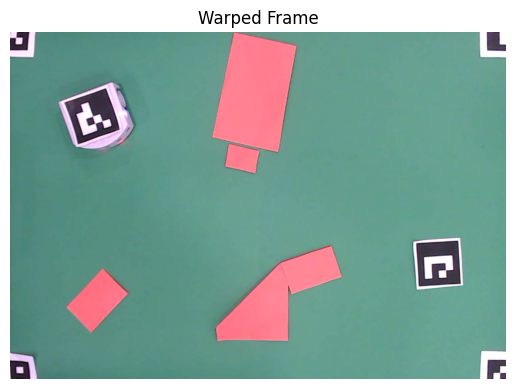

In [4]:
warped_frame = vision.get_warped_frame(raw_frame)

plt.imshow(cv2.cvtColor(warped_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Warped Frame')
plt.show()

Global Obstacle Detection

The global obstacles are detected once, at the start of the program. We make the assumption that these obstacles shouldn't change during the run so it is unnecessary to detect them more than once. This also makes the obstacle detection more robust during the run as it solves a problem: if the robot accidentally occludes an obstacle from the camera’s perspective, the detected obstacle would be altered, potentially modifying the planned path at runtime, which is undesirable for stable navigation.

In our setup, the obstacles are of bright red color. In order to detect them we follow the following steps:  

1 - Color thresholding  
We first convert the image color system from 'Blue Green Red' (BGR) to 'Hue Saturation Value' (HSV). HSV is a different color system with three components, the hue of the color, the saturation, and the value. Among simple and fast alternatives such as keeping BGR and grayscale, HSV stands out as the most reliable choice for this task. RGB is often unstable, as a “red” object may appear as a dark maroon under shadow, causing significant variation across all three channels. Similarly, a grayscale thresholding approach was excluded because it discards chromatic information, making red and green objects potentially indistinguishable when they share similar luminance or are affected by uneven lighting.
In contrast, HSV preserves color information more robustly: the hue remains relatively constant even when brightness fluctuates, and the red objects in our scene are highly saturated compared to the black-and-white ArUco marker. This makes red–green separation significantly more stable against shadows and illumination changes.
However, HSV is very sensitive to lighting changes and to have a robust threshold to distinguish obstacles, it is needed to recompute the threshold when the lighting changes. To address this, we developed a dedicated tool, `hsv_tuner.py`, which allows manual adjustment of the threshold ranges in real time. This tool enables us to tweak the HSV values and immediately visualize their effect on the filtered image, making re-tuning faster and more controlled.
  
2 - Once we know what the best HSV range for distinguishing the obstacles is, we apply a threshold range to the frame in order to get a binary mask. In order to remove noisy detections, we apply morphological opening to obtain a clean binary mask. Since the Thymio robot also emits red light from its LEDs, we explicitly exclude it from detection by forcing all pixels in the robot's radius to black (not an obstacle) to make sure it isn't considered as an obstacle (more on the Thymio detection later).

3 - We now have a noise-robust binary mask that tells us if each pixel is from an obstacle (white) or not (black). We can now try to understand where the obstacles are. In order to get the shapes of the obstacles, we approximate their shapes to polygons, using the `_mask_to_polygons()` function. This function takes as input the clean mask and returns the list of polygons (each polygon being a list of its different vertices). 

4 - To make sure that the thymio doesn't collide with global obstacles, we create a buffer space of the thymio's radius around all obstacle polygons. We expand all polygons using the `_expand_and_merge_polygons()` and if two expanded polygons end up being superposed, we merge them together and consider them as one big obstacle polygon. These final polygons vertices coordinates are returned by the obstacle detection function and will be used later for gloabl path planning.

The choice of approximating the obstacles with polygons was motivated by the computation complexity of global navigation. This method allows us to limit the number of vertices to consider in the navigation unit, making it a lot more efficient.

Note: Before building the obstacle map, we perform a 2-second camera warm-up to allow auto-exposure and white-balance to stabilize and to flush initial buffered frames. This prevents the first detection cycle from misinterpreting the scene (e.g. overexposed frames), avoiding incorrect maps that could mislead the planner. Right after warm-up, obstacle detection is computed using the median of multiple (5) consecutive frames rather than a single snapshot. Taking the pixel-wise median reduces sensor noise and removes transient artifacts, ensuring that only persistent red regions are classified as obstacles.


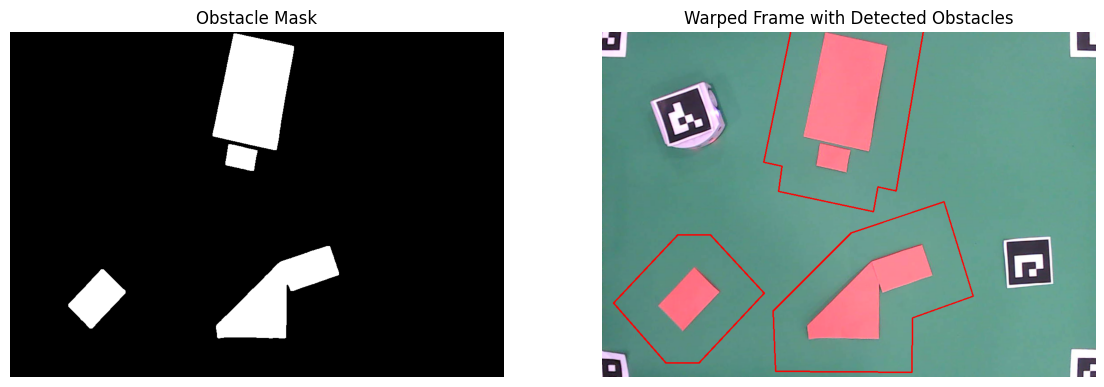

In [5]:
obstacles, obstacle_mask = vision.detect_obstacles(frame = warped_frame)
obstacles_frame = warped_frame.copy()
vision.draw(frame = obstacles_frame, obstacles = obstacles)

fig, axs = plt.subplots(1,2, figsize=(14,6))
axs[0].imshow(obstacle_mask, cmap='gray')
axs[0].set_title("Obstacle Mask")
axs[0].axis('off')
axs[1].imshow(cv2.cvtColor(obstacles_frame, cv2.COLOR_BGR2RGB))
axs[1].set_title("Warped Frame with Detected Obstacles")
axs[1].axis('off')
plt.show()

Thymio and Goal Detection



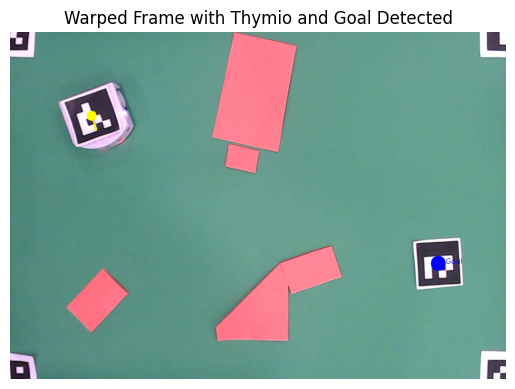

In [6]:
thymio_pose = vision.get_thymio_pose(warped_frame)
goal_pos = vision.get_goal_pos(warped_frame)
pose_frame = warped_frame.copy()
vision.draw(frame = pose_frame, pose=thymio_pose, goal=goal_pos)
plt.imshow(cv2.cvtColor(pose_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Warped Frame with Thymio and Goal Detected')
plt.show()


In [ ]:
vision.delete_matrix()

## Global Navigation

## Local Navigation

## Filtering

Extended Kalman filter
In real life, the robot’s position cannot be exactly defined as there are uncertainties from various sources such as sensor noise and motor friction. Hence, it is helpful to have measurements gathered in multiple way to increase the precision of the robot's localisation. To do so, the extended Kalman filter is used in this project to merge the data obtained from the robot’s encoder and position information from ARUCO markers scanned by webcam. 


With the covariance matrix Q and R obtained at the initialization phase, 

## Motion Control

## Overall Project
### Main function

The modules described previously are all merged in the main function. The main.py script orchestrates the flow of data between perception, planning, and control modules within a continuous asynchronous loop. The architecture is designed to be reactive, constantly updating its decisions based on the latest sensor readings and visual data. 

#### Initialization phase
Before the robot begins its mission, the system performs a critical setup sequence:
1. Connection: The script establishes a connection to the Thymio via the tdmclient. It "locks" the robot node to ensure exclusive control over the motors and sensors.
2. Vision Setup: The Vision class is instantiated. It attempts to load the calibration matrix. If the matrix is missing, it triggers the automated calibration routine.
3. Static Mapping: The system forces the camera to run for 2 seconds to adjust exposure/color and then captures a single stable image of the arena with static obstacles. It detects the red obstacles and generates the expanded polygons (C-Space) that will be used by the global path planner. This "static map" assumption allows us to compute the obstacle geometry only once, saving processing power for the main loop and also avoiding the Thymio to cover obstacles by changing the navigation plan without any real reason.


#### The control loop
Once initialized, the system enters a while True loop. Each iteration follows a strict Perceive-Plan-Act cycle:
##### Step 1: Perception
The robot gathers data from two independent sources:
* Camera: The camera captures a new frame. The Vision module processes this frame to find the current pose of the Thymio (Marker 0) and the Goal (Marker 1).
* Prox_sensors: The script reads the raw values from the Thymio's horizontal proximity sensors (prox.horizontal). It calculates the maximum value among the front sensors to detect imminent collisions.
##### Step 2: State estimation
Real-world data is noisy. The camera might flicker, or a shadow might obscure a marker. To handle this, we implemented a State Estimator with Resilience:
* If the marker is detected, the pose is updated, and the timestamp is recorded.
* If the marker is lost (detection fails), the system enters a "Coasting" mode. It assumes the robot is still at the last known valid position for a short duration (MAX_BLIND_DURATION = 0.5s).
* If the blindness persists beyond 0.5s, the system declares the robot "Lost" and triggers a safety stop.


## Conclusion